In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from collections import Counter
import math
import glob
import re

In [2]:
def read_vtk_points(filename):
    """
    Read the coordinates from a VTK PolyData file with POINTS.
    Returns an (N,3) NumPy array of floats.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
    points = []
    for i, line in enumerate(lines):
        if line.strip().startswith("POINTS"):
            parts = line.split()
            if len(parts) >= 3:
                n_points = int(parts[1])             # number of points
                # Read the next n_points lines of coordinates
                for j in range(i+1, i+1+n_points):
                    coords = list(map(float, lines[j].split()))
                    points.append(coords)
            break
    return np.array(points)

def helix_contacts_and_lengths(coords):
    """
    Given an (N,3) array of bead positions and cutoff Rc,
    find i+4 contacts with distance < 0.85*Rc. Returns:
    - total_contacts: total number of i<->i+4 contacts below cutoff
    - helix_lengths: list of helix lengths (m-1) for each continuous segment of contacts
    """
    N = len(coords)
    cutoff = 0.85 
    contacts = []
    postions=[]
    for i in range(N-4):
        d = math.dist(coords[i], coords[i+4])
        if d< cutoff:
            contacts.append(True)
            postions.append(i)
        else:
            contacts.append(False)
        
    total_contacts = sum(contacts)
    # Find contiguous runs of True in contacts
    helix_lengths = []
    run_length = 0
    for flag in contacts:
        if flag:
            run_length += 1
        else:
            if run_length > 0:
                # Compute helix length for this run
                full_turns = math.floor((run_length-1)*0.25) + 1
                length = full_turns - 1
                helix_lengths.append(length)
            run_length = 0
    # handle last run if it ends at end
    if run_length > 0:
        full_turns = math.floor((run_length-1)*0.25) + 1
        helix_lengths.append(full_turns - 1)
    return total_contacts,postions, helix_lengths

def process_trial(trial_path, trial_id):
    results = []

    vtk_files = sorted(glob.glob(os.path.join(trial_path, "*.vtk")))

    for filepath in vtk_files:
        coords = read_vtk_points(filepath)
        if coords.size == 0:
            continue

        total_contacts, positions, lengths = helix_contacts_and_lengths(coords)

        results.append({
            "trial": trial_id,
            "filename": os.path.basename(filepath),
            "timestep": int(re.sub('dmpccs.001.con.', '', os.path.basename(filepath))[:-4]),
            "num_contacts": total_contacts,
            "contact_positions": positions,
            "helix_lengths": lengths
        })

    df = pd.DataFrame(results).sort_values("timestep")
    return df

In [5]:
base_path = "Runs/"
trial_dirs = sorted(glob.glob(os.path.join(base_path, "Trial=*")))
dfs = []

for trial_path in trial_dirs:
    trial_id = os.path.basename(trial_path).removeprefix('Trial=')  # e.g. "Trial=6"
    print(trial_id)
    df_trial = process_trial(trial_path, trial_id)
    dfs.append(df_trial)

df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("all_trials_contacts.csv", index=False)

0
1
2


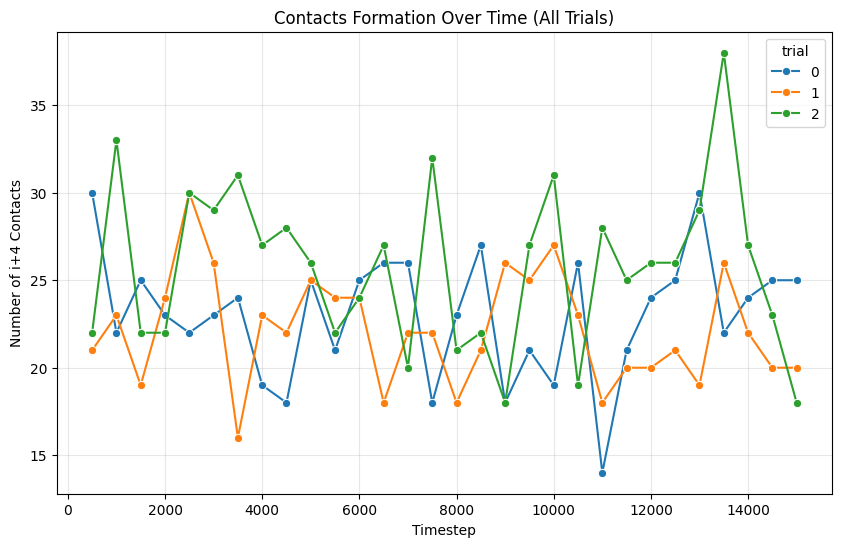

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_all,
    x="timestep",
    y="num_contacts",
    hue="trial",
    marker="o"
)
plt.xlabel("Timestep")
plt.ylabel("Number of i+4 Contacts")
plt.title("Contacts Formation Over Time (All Trials)")
plt.grid(alpha=0.3)
plt.show()

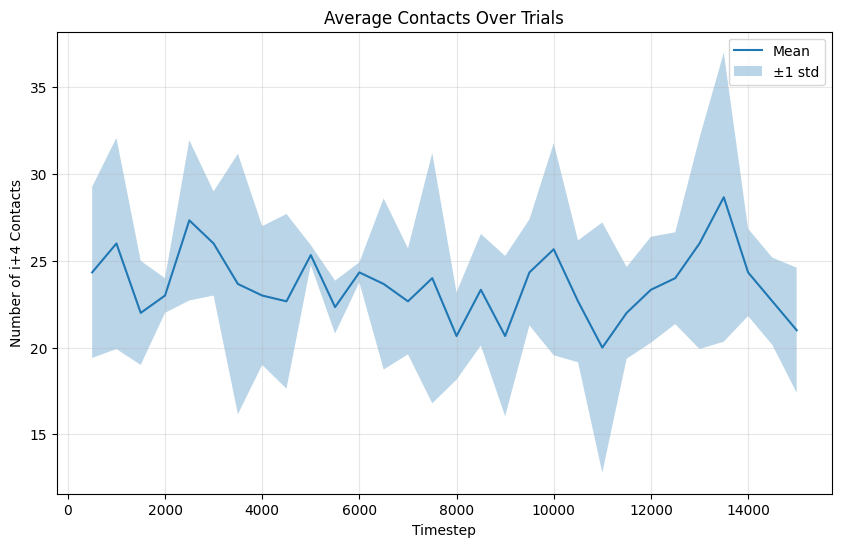

In [7]:
df_stats = (
    df_all
    .groupby("timestep")["num_contacts"]
    .agg(["mean", "std"])
    .reset_index()
)

plt.figure(figsize=(10, 6))
plt.plot(df_stats["timestep"], df_stats["mean"], label="Mean")
plt.fill_between(
    df_stats["timestep"],
    df_stats["mean"] - df_stats["std"],
    df_stats["mean"] + df_stats["std"],
    alpha=0.3,
    label="±1 std"
)
plt.xlabel("Timestep")
plt.ylabel("Number of i+4 Contacts")
plt.title("Average Contacts Over Trials")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

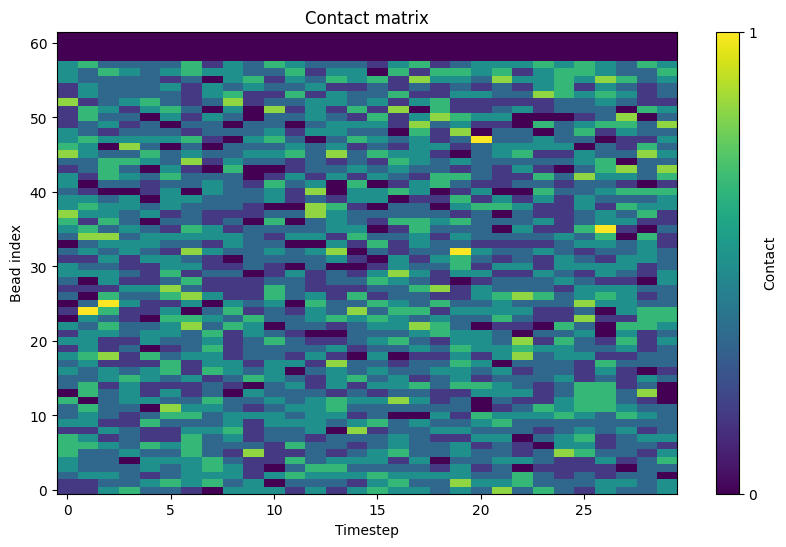

In [6]:
N_BEADS = 62
T = 30
contact_prob = np.zeros((T, N_BEADS))

for trial_id, df_trial in df_all.groupby("trial"):
    mat = np.zeros((T, N_BEADS))
    for t, contacts in enumerate(df_trial["contact_positions"]):
        mat[t, contacts] = 1
    contact_prob += mat

contact_prob /= df_all["trial"].nunique()
cmap = ListedColormap(["black", "green"])

plt.figure(figsize=(10, 6))
plt.imshow(
    contact_prob.T,  
    aspect="auto",
    origin="lower"
)

plt.xlabel("Timestep")
plt.ylabel("Bead index")
plt.title("Contact matrix")

plt.colorbar(label="Contact", ticks=[0, 1])
plt.savefig("contact_matrix.png", dpi=300, bbox_inches="tight")
plt.show()




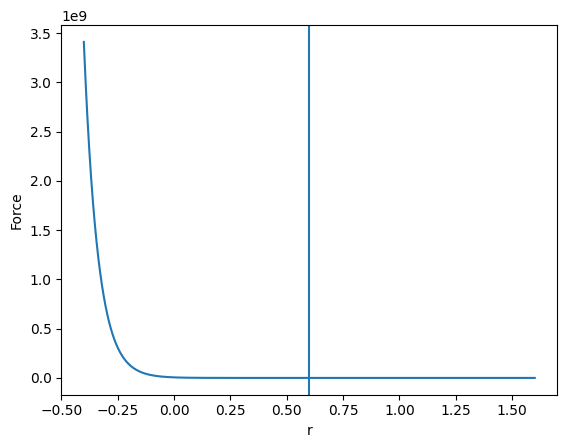

In [6]:
rMe=0.6
KM= 24
alpha=8
r = np.linspace(rMe - 1, rMe + 1, 500)
F = 2*KM*alpha*np.exp(-alpha*(r-rMe))*(np.exp(-alpha*(r-rMe)) - 1)
plt.plot(r, F)
plt.axvline(rMe)
plt.xlabel("r")
plt.ylabel("Force")
plt.show()